In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs

In [2]:
btc_data = pd.read_csv('BITSTAMP_BTCUSD, 1D_62909.csv')
btc_data['time'] = btc_data['time'].apply(lambda x: x.replace('T08:00:00+08:00', ''))
btc_data.set_index('time', inplace=True)
btc_data['HV'] = btc_data['HV'] * 0.01

In [4]:
bvix_data = pd.read_csv('VOLMEX_BVIV, 1D_9d901.csv')
bvix_data['time'] = bvix_data['time'].apply(lambda x: x.replace('T22:30:00+08:00', ''))
bvix_data['time'] = bvix_data['time'].apply(lambda x: x.replace('T21:30:00+08:00', ''))
bvix_data.set_index('time', inplace=True)
bvix_data.index = pd.to_datetime(bvix_data.index)
bvix_data.index = [time.strftime('%Y-%m-%d') for time in bvix_data.index]

In [22]:
IV_backtest_data = bvix_data['close']*0.01

In [23]:
HV_backtest_data = btc_data.loc[IV_backtest_data.index[0]:IV_backtest_data.index[-1]]['HV']

In [32]:
def BB(data, rolling_window, std_multiplier):
    SMA = data.rolling(window=rolling_window).mean()
    std = data.rolling(window=rolling_window).std()
    lower_bound = SMA - std_multiplier*std
    upper_bound = SMA + std_multiplier*std
    
    return SMA, lower_bound, upper_bound

def VRP_BB_bound_sharpe(df):
    
    df.index = pd.to_datetime(df.index, utc=True)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['close']) 
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    pct_return = pd.DataFrame((close_price - open_price)/open_price)
    sharpe_ratio = qs.stats.sharpe(pct_return, periods=365)
    freq = len(pct_return)

    if freq == 0:
        sharpe_ratio = np.nan
        
    return sharpe_ratio

def VRP_BB_bound(df):
    
    df.index = pd.to_datetime(df.index, utc=True)
    open_date = []
    close_date = []
    open_position = False
    open_price = []
    close_price = []

    for date, row in df.iterrows():
        
        last_index_condtion = date == df.index[-1]
        
        if row['VRP'] <= row['lower_band'] and not open_position:
            open_date.append(date)
            open_price.append(row['close'])
            open_position = True

        if (row['VRP'] >= row['middle_band'] or last_index_condtion) and open_position == True:
            close_date.append(date)
            close_price.append(row['close'])
            open_position = False
            
    open_price = np.array(open_price)
    close_price = np.array(close_price)
    open_date = np.array(open_date)
    close_date = np.array(close_date)
    
    profit = close_price - open_price 
    abs_profit = abs(profit)
    freq = len(profit)
    holding = close_date - open_date

    if freq != 0:   
        winning_rate = len(profit[profit > 0]) / freq
        holding_median = np.median(holding).days
        profit_median = np.median(abs_profit)
        
    else: 
        winning_rate = np.nan
        holding_median = np.nan
        profit_median = np.nan
        
    return winning_rate, freq, holding_median, profit_median

In [30]:
# Tuning parameters
rolling_window_list = [10]
std_multiplier_list = [1.5]
winning_rate_list = []

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}
result_dict['rolling_window'] = []
result_dict['std_multiplier'] = []
result_dict['winning_rate'] = []
result_dict['Freq'] = []
result_dict['median_holding_period'] = []
result_dict['volatility_median'] = []

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]

        IV_backtest_data.index = pd.to_datetime(IV_backtest_data.index)
        IV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in IV_backtest_data.index]
        
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        winning_rate, freq, holding_median, volatility_median, open_date = VRP_BB_bound(df)
        
        result_dict['rolling_window'].append(rolling_window)
        result_dict['std_multiplier'].append(std_multiplier)
        result_dict['winning_rate'].append(winning_rate)
        result_dict['Freq'].append(freq)
        result_dict['median_holding_period'].append(holding_median)
        result_dict['volatility_median'].append(volatility_median)
            
result_df = pd.DataFrame.from_dict(result_dict)

Text(0.5, 1.0, 'Sharpe_ratio')

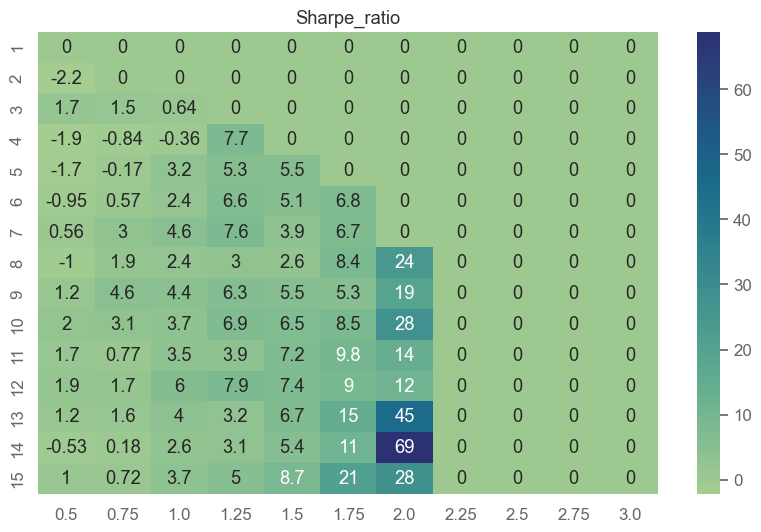

In [25]:
rolling_window_list = list(range(1,16))
std_multiplier_list = np.array(list(range(50, 325, 25)))/100

VRP = IV_backtest_data-HV_backtest_data
VRP = VRP.rename('VRP')

result_dict = {}

for rolling_window in rolling_window_list:
    for std_multiplier in std_multiplier_list:
        
        middle_band, lower_band, upper_band = BB(VRP, rolling_window, std_multiplier)

        lower_band = lower_band.rename('lower_band')
        upper_band = upper_band.rename('upper_band')
        middle_band = middle_band.rename('middle_band')

        HV_backtest_data.index = pd.to_datetime(HV_backtest_data.index)
        HV_backtest_data.index = [time.strftime('%Y-%m-%d') for time in HV_backtest_data.index]
        df = pd.concat([HV_backtest_data, IV_backtest_data, middle_band, upper_band, lower_band, VRP], axis=1)
        
        sharpe_ratio = VRP_BB_bound_sharpe(df)
        
        result_dict.update({(rolling_window, std_multiplier):float(sharpe_ratio)})

ser = pd.Series(list(result_dict.values()), index=pd.MultiIndex.from_tuples(result_dict.keys()))
sharpe  = ser.unstack().fillna(0)
sns.heatmap(sharpe, annot = True, cmap = "crest").set_title('Sharpe_ratio')

In [27]:
result_df[result_df['rolling_window'] == 10]

,rolling_window,std_multiplier,winning_rate,Freq,median_holding_period,volatility_median
99,10,0.50,0.526316,19,5.0,0.030398
100,10,0.75,0.578947,19,5.0,0.029069
101,10,1.00,0.647059,17,7.0,0.025701
102,10,1.25,0.666667,15,7.0,0.027057
103,10,1.50,0.583333,12,8.0,0.034238
104,10,1.75,0.750000,8,8.0,0.054948
105,10,2.00,1.000000,4,8.0,0.062470
106,10,2.25,NaN,0,NaN,NaN
107,10,2.50,NaN,0,NaN,NaN
108,10,2.75,NaN,0,NaN,NaN
